# Multi-Agent RAG Support System

## Setup and Imports


In [1]:
import json
from uuid import uuid4
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

from langchain.chat_models import init_chat_model

from pydantic import BaseModel 
from typing import List, Dict

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
import os
from dotenv import load_dotenv
from typing import TypedDict, Literal
from langchain_core.documents import Document
from IPython.display import Image, display
from langgraph.graph import StateGraph, START 
from langgraph.types import Command

In [2]:
root_dir = os.path.abspath(".")
env_file = os.path.abspath(os.path.join(root_dir, ".env"))

In [3]:
EMBEDDING_MODEL = "text-embedding-3-small"
COMPLETION_MODEL = "gpt-4.1-mini"

In [4]:
# Try to load environment variables from env_file (if present). If loading fails, fall back to defaults.
if os.path.exists(env_file):
    load_dotenv(env_file)
    EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL", EMBEDDING_MODEL)
    COMPLETION_MODEL = os.getenv("COMPLETION_MODEL", COMPLETION_MODEL)
    LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
    LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY")
    LANGFUSE_BASE_URL = os.getenv("LANGFUSE_BASE_URL")   

In [5]:
embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)

In [6]:
def print_highlighted_json(json_dict: dict):
    highlight(json.dumps(json_dict, indent=4), JsonLexer(), TerminalFormatter())
    """Prints a JSON string with syntax highlighting for terminal output."""
    highlighted_json = highlight(json.dumps(json_dict, indent=4), JsonLexer(), TerminalFormatter())
    print(highlighted_json)

## Document loading and vector stores 


In [7]:
def open_vector_store(db_dir:str, collection_name:str):
    # Create or load the Chroma vector store 
    vector_store = Chroma(
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory=db_dir,  # Where to save data locally, remove if not necessary
    )
    return vector_store

def build_vector_store(db_dir:str, document_path:str, collection_name:str):
    # Read the FAQ markdown document
    with open(document_path, "r") as file:
        faq_md_content = file.read()

    headers_to_split_on = [
        ("#", "H1"),
        ("##", "H2"),
    ]

    # Split markdown content into chunks based on headers
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on)
    md_header_splits = markdown_splitter.split_text(faq_md_content)

    uuids = [str(uuid4()) for _ in md_header_splits]
    vector_store = open_vector_store(db_dir=db_dir, collection_name=collection_name)
    vector_store.add_documents(documents=md_header_splits, ids=uuids)

### Build the Vector Stores

In [8]:
# # Uncomment this code block to build the vector stores for each domain-specific document

# raw_docs = {
#     "hr": "data/hr_docs/hr.md",
#     "tech": "data/tech_docs/tech.md",
#     "finance": "data/finance_docs/finance.md",
# }
#
# for key, val in raw_docs.items():
#     build_vector_store(
#         db_dir="chroma_db",
#         document_path=val,
#         collection_name=f"{key}_collection"
#     )

## Agent definitions 


In [9]:
class State(TypedDict):
    user_query: str
    intent_category: Literal["hr", "tech", "finance"]
    answer: str
    retrieved_documents: List[Dict]

class Classification(BaseModel):
    intent_category: Literal["hr", "tech", "finance"] 
# Initialize the chat model with specified parameters

def orchestrator_agent(state: State) -> Command[Literal["hr_agent", "tech_agent", "finance_agent"]]:
    """
    Classify the user query into predefined categories.
    """
    model = init_chat_model(
        COMPLETION_MODEL,
        temperature=0.3,
        model_kwargs={
            "response_format":Classification
        },
    )
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Classify the user's query into one of the following categories: technical support questions (`tech`), human resources questions (`hr`), and finance questions (`finance`)."},
        {"role": "user", "content": state["user_query"] }
    ]
    response = model.invoke(
        messages, 
        )
    classification =  json.loads(response.content)
    return Command(
        update = classification,
        goto = classification["intent_category"] + "_agent"
    )


def hr_agent(state: State):
    model = init_chat_model(
        COMPLETION_MODEL,
        temperature=0.3
    )
    collection = "hr_collection"
    vector_store = open_vector_store(
        db_dir="chroma_db",
        collection_name=collection
    )
    retrieved_docs = vector_store.similarity_search(state["user_query"])
    def format_user_prompt(user_question:str , chunks:list) -> str:
        return f"# Context\n{'\n\n---\n\n'.join(chunks)}\n\n# Question\n{user_question}"
    chunks = [doc.page_content for doc in retrieved_docs]
    # Fromat user prompt with context
    formatted_prompt = format_user_prompt(state["user_query"], chunks)
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Answer the user's question based on the context provided."},
        {"role": "user", "content": formatted_prompt }
    ]
    message = model.invoke(messages)
    return {"answer": message.content, "retrieved_documents": [doc.model_dump() for doc in retrieved_docs]}

def tech_agent(state: State):
    model = init_chat_model(
        COMPLETION_MODEL,
        temperature=0.3
    )
    collection = "tech_collection"
    vector_store = open_vector_store(
        db_dir="chroma_db",
        collection_name=collection
    )
    retrieved_docs = vector_store.similarity_search(state["user_query"])
    def format_user_prompt(user_question:str , chunks:list) -> str:
        return f"# Context\n{'\n\n---\n\n'.join(chunks)}\n\n# Question\n{user_question}"
    chunks = [doc.page_content for doc in retrieved_docs]
    # Fromat user prompt with context
    formatted_prompt = format_user_prompt(state["user_query"], chunks)
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Answer the user's question based on the context provided."},
        {"role": "user", "content": formatted_prompt }
    ]
    message = model.invoke(messages)
    return {"answer": message.content, "retrieved_documents": [doc.model_dump() for doc in retrieved_docs]}

def finance_agent(state: State):
    model = init_chat_model(
        COMPLETION_MODEL,
        temperature=0.3
    )
    collection = "finance_collection"
    vector_store = open_vector_store(
        db_dir="chroma_db",
        collection_name=collection
    )
    retrieved_docs = vector_store.similarity_search(state["user_query"])
    def format_user_prompt(user_question:str , chunks:list) -> str:
        return f"# Context\n{'\n\n---\n\n'.join(chunks)}\n\n# Question\n{user_question}"
    chunks = [doc.page_content for doc in retrieved_docs]
    # Fromat user prompt with context
    formatted_prompt = format_user_prompt(state["user_query"], chunks)
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Answer the user's question based on the context provided."},
        {"role": "user", "content": formatted_prompt }
    ]
    message = model.invoke(messages)
    return {"answer": message.content, "retrieved_documents": [doc.model_dump() for doc in retrieved_docs]}


## Orchestrator and routing 


In [10]:
workflow = StateGraph(State)
workflow.add_node(orchestrator_agent)
workflow.add_node(hr_agent)
workflow.add_node(tech_agent)
workflow.add_node(finance_agent)
workflow.add_edge(START, "orchestrator_agent")
chain = workflow.compile()

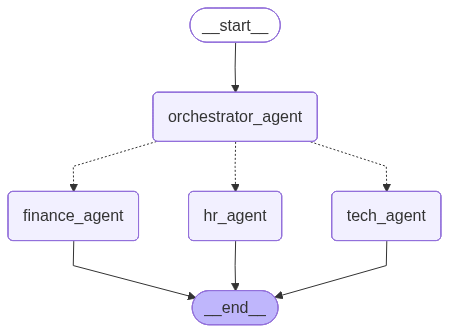

In [11]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [12]:
#print(chain.get_graph().draw_mermaid())

## Testing & examples


In [13]:
test_queries = [
    {"query": "What is the PTO accrual rate for employees with 3–5 years of service?", "intent_category": "hr"},
    {"query": "Who must approve purchases exceeding $100,000?", "intent_category": "finance"},
    {"query": "What are the steps and requirements for an emergency password reset?", "intent_category": "tech"},
    {"query": "Which VPN client is used and where do employees download it?", "intent_category": "tech"},
    {"query": "What are the approval limits for (a) individual employees, (b) department managers, and (c) directors for purchases?", "intent_category": "finance"},
    {"query": "How long is the new‑hire probationary period and what are the evaluation/termination rules during it?", "intent_category": "hr"},
    {"query": "What are the company password complexity and expiration requirements?", "intent_category": "tech"},
    {"query": "What is the corporate credit card monthly spending limit per card?", "intent_category": "finance"},
    {"query": "What is the procedure to enroll a mobile device in the company MDM (Intune)?", "intent_category": "tech"},
    {"query": "What documentation and steps are required for Accounts Payable three-way matching before payment?", "intent_category": "finance"}
]

In [14]:
for i, (test_query, intent_category) in enumerate([q.values() for q in test_queries], start=1):
    print(f"\n\nUser Query {i}: {test_query}")
    print(f"Reference Intent Category {i}: {intent_category}\n")
    state = chain.invoke(State(user_query=test_query))
    print("Output state:\n")
    print_highlighted_json(state)
    print("\n" + "="*80 + "\n")



User Query 1: What is the PTO accrual rate for employees with 3–5 years of service?
Reference Intent Category 1: hr

Output state:

{
    "user_query": "What is the PTO accrual rate for employees with 3\u20135 years of service?",
    "intent_category": "hr",
    "answer": "The PTO accrual rate for employees with 3\u20135 years of service is 20 days per year.",
    "retrieved_documents": [
        {
            "id": "d173189a-db42-442d-849b-2d8b8a7d823f",
            "metadata": {
                "H1": "Company HR Policies and Procedures Manual",
                "H2": "27. Paid Time Off (PTO) Policy"
            },
            "page_content": "Full-time employees accrue PTO combining vacation, sick time, and personal days. Accrual rates increase with tenure: 0-2 years (15 days), 3-5 years (20 days), 6+ years (25 days). PTO requests require advance approval. Unused PTO up to 40 hours rolls over annually. Departing employees receive payout of accrued unused PTO.",
            "type": "

In [15]:
# query = test_queries[3]["query"]
# state = chain.invoke({"user_query": query})
# print_highlighted_json(state)

In [16]:
# state = State(
#     user_query="What is the process for applying for parental leave?",
#     query_type="hr",
#     retrieved_documents=[],
#     answer=""
# )

In [17]:
# collection = "hr_collection"
# vector_store = open_vector_store(
#     db_dir="chroma_db",
#     collection_name=collection
# )
# retrieved_docs = vector_store.similarity_search(query)

## Langfuse integration

In [18]:
from langfuse.langchain import CallbackHandler

In [19]:
langfuse_handler = CallbackHandler()


In [20]:
query = test_queries[3]["query"]

In [21]:
state = chain.invoke(
    {"user_query": query},
    config={"callbacks": [langfuse_handler]} # Add Langfuse callback handler here
)

In [22]:
print_highlighted_json(state)

{
    "user_query": "Which VPN client is used and where do employees download it?",
    "intent_category": "tech",
    "answer": "The VPN client used is Cisco AnyConnect. Employees can download it from https://vpn.company.com.",
    "retrieved_documents": [
        {
            "id": "e6d634cd-f11d-425f-a3e3-25e099dc20fa",
            "metadata": {
                "H1": "2. VPN Access and Configuration",
                "H2": "2.1 VPN Installation Process"
            },
            "page_content": "To install company VPN (Cisco AnyConnect):\n1. Navigate to https://vpn.company.com\n2. Download the appropriate client for your OS (Windows/Mac/Linux)\n3. Run installer with administrator privileges\n4. Enter company credentials when prompted\n5. Configure split-tunneling if approved by security team",
            "type": "Document"
        },
        {
            "id": "e4d1543d-ec50-44d2-b4c4-5a3e0ffaeb0c",
            "metadata": {
                "H2": "2.3 VPN Best Practices",
      